$$\Huge{\textnormal{\color{darkgreen}{Анализ ВВП Республики Гана }}}$$  
$$\huge{\textnormal{\blue{Практическая работа}}}$$
  
---------------

In [24]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import warnings
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

In [25]:
# Информация о признаках, пропусках и дубликатах
def inf(data, raw=0):
    display(data.head(raw)) if raw !=0 else 0
    raw = data.shape[0]
    col = data.shape[1]
    duble = data.duplicated().sum()
    nan_all = data.isnull().sum().sum()
    if nan_all == 0:
        none_nan = "NaN not detected."
    else:
        none_nan = data.isnull().sum().to_frame(name='NaN').query('NaN>0')
    print(f"Строки: {raw} \nПризнаки: {col} \nДубликаты: {duble} \nПропуски: {none_nan}")
    
# Тест Дики ─ Фуллера
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['Значение теста ADF:','p-value:', 'Использовано лагов:','Количество наблюдений', 'Критические значения:']
    # print ('Critical values: ', result[4])
    for value,label in zip(result,labels):
        print(label+' '+str(value))
    if result[1] <= 0.05:
        print("\nP-value меньше 0.05, нулевую гипотезу (Ho) можно отвергнуть.", "\nРяд стационарен.")
    else:
        print("\nПолученные данные не позволяют отвергнуть нулевую гипотезу.", "\nРяд нестационарен.")
    # return result[1]

# Дифференцирование и определение d
def diff(data):
    diff_num = 0
    adf_test = adfuller(data)
    while adf_test[1] > 0.05:
        diff_num += 1
        adf_test = adfuller(data.diff(diff_num).dropna())
    return diff_num

# Графики Autocorrelation и Partial Autocorrelation
def plot_acf_pacf(series, n_lags=10, width=10, hight=5):
    plt.rcParams["figure.figsize"] = width, hight
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, lags = n_lags, ax = axes[0])
    sgt.plot_pacf(series, lags = n_lags, ax = axes[1])
    plt.show();

$\huge{\textnormal{\color{Peru}{1. Статистические модели прогнозирования}}}$  
  
$\Large{\textbf{\color{darkgreen}{Задание 1.1}}}$  
 Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

In [26]:
# Чтение исходного файла
df = pd.read_csv("data/ghana_gdp.zip", parse_dates=["year"], index_col = ["year"])
inf(df)
df.head()

Строки: 62 
Признаки: 1 
Дубликаты: 0 
Пропуски: NaN not detected.


,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [27]:
# делаем train-выборку
train_df = df.loc[:"2018-01-01"]
# для test-выборки используем последние три года
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

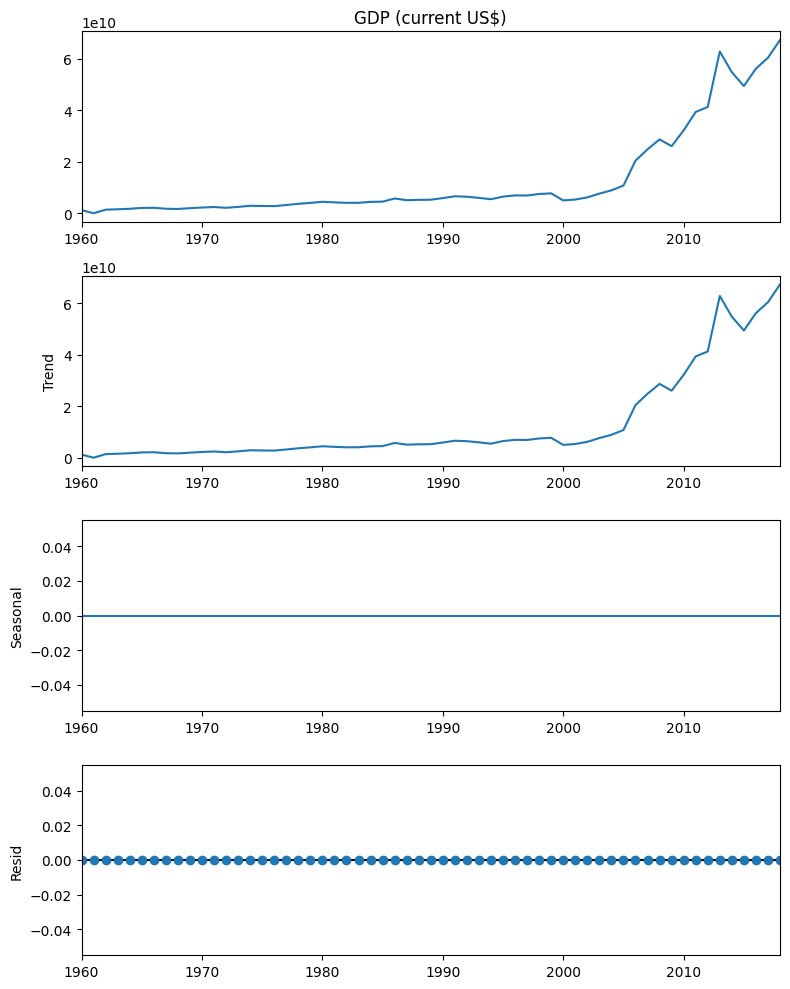

In [28]:
# Визуализация исходного ряда, декомпозиция
plt.rcParams["figure.figsize"] = 8, 10

result = seasonal_decompose(train_df['GDP (current US$)'], model='additive')
result.plot()
plt.show();

В первичном выводе можно сказать, что присутствует явный тренд и сезонность не наблюдается.  
  
Тестовая выборка ─ последние три года: 2019, 2020, 2021

$\Large{\textbf{\color{darkgreen}{Задание 1.2}}}$  
Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.  
  
Пример: `train_df.spx.rolling(window=2).mean()`  
  
Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.  

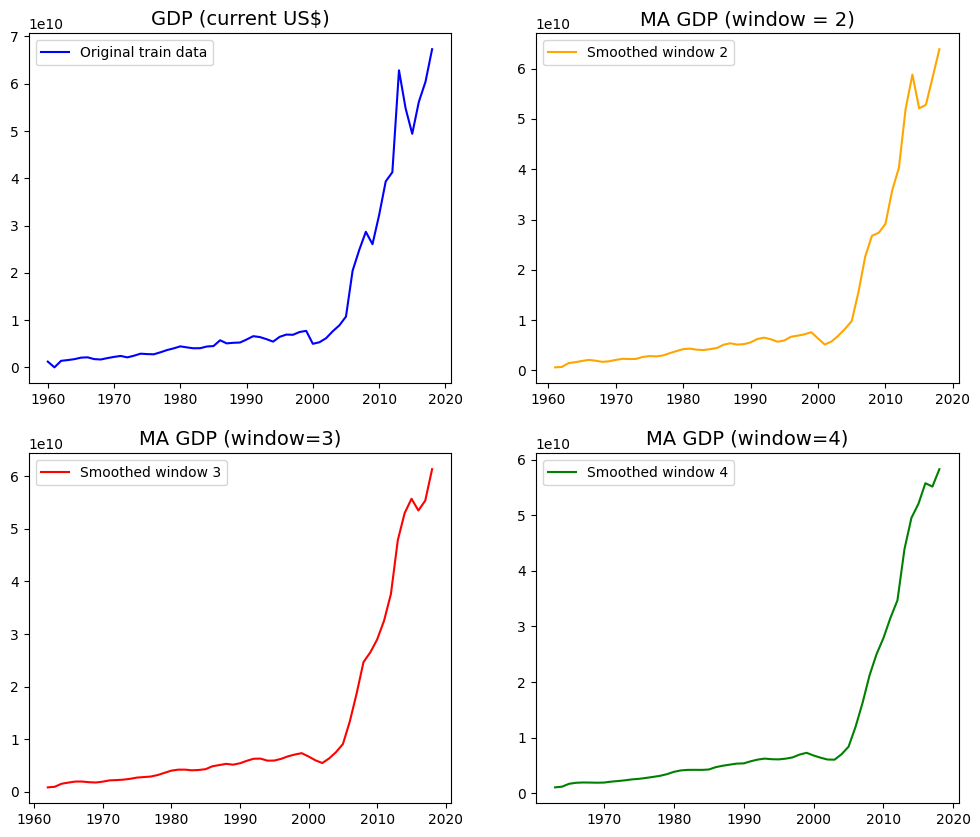

In [29]:
# визуализация временного ряда со скользящим средним
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_df['GDP (current US$)'], color = "blue", label = "Original train data")
ax[0, 0].set_title("GDP (current US$)", size = 14)
ax[0, 0].legend()

ax[0, 1].plot(train_df['GDP (current US$)'].rolling(window=2).mean(), color = "orange", label = "Smoothed window 2")
ax[0, 1].set_title("MA GDP (window = 2)", size = 14)
ax[0, 1].legend()

ax[1, 0].plot(train_df['GDP (current US$)'].rolling(window=3).mean(), color = "red", label = "Smoothed window 3")
ax[1, 0].set_title("MA GDP (window=3)", size = 14)
ax[1, 0].legend()

ax[1, 1].plot(train_df['GDP (current US$)'].rolling(window=4).mean(), color = "green", label = "Smoothed window 4")
ax[1, 1].set_title("MA GDP (window=4)", size = 14)
ax[1, 1].legend();

Скользящее среднее с окном два года (жёлтая кривая) неэффективно борется с выбросами.  
Скользящее среднее с окном четыре года (зелёная кривая) слишком эффективно, возможны потери в данных  

$\Large{\textbf{\color{darkgreen}{Задание 1.3}}}$  
С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели *ARMA/ARIMA*.  
  
>**Примечание.**  
Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым.  
Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим  
параметром ***d*** для модели *ARIMA*.  
  
Параметры ***p*** и ***q*** выберите по коррелограммам **ACF** и **PACF**.  
  
>**Примечание.**  
Помните, что параметры ***p*** и ***q*** для *ARMA/ARIMA* определяются из коррелограмм стационарного ряда.  
То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для  
разностей того порядка, которые являются стационарными.  
  
Постройте модель *ARMA/ARIMA* для прогнозирования поведения временного ряда.  
Также постройте несколько моделей с параметрами, ближайшими к найденным ***p*** и ***q***, и сравните коэффициент *AIC* (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

In [30]:
# Тест Дики ─ Фуллера
adfuller_test(train_df["GDP (current US$)"])

Значение теста ADF: 0.6529066974885367
p-value: 0.9888496277665573
Использовано лагов: 10
Количество наблюдений 48
Критические значения: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Полученные данные не позволяют отвергнуть нулевую гипотезу. 
Ряд нестационарен.


Значение из теста (0.6529) больше всех критических значений, p-value > 0.05, а также, помимо p-value, все данные говорят о том, что нулевую гипотезу нельзя отвергнуть.  
Ряд нестационарен. Необходимо провести дифференциацию ряда.

In [31]:
# Дифференциация и определение порядка DS-ряда
d = diff(train_df['GDP (current US$)'])
print(f"При d = {d} ряд становится стационарным\n")
adfuller_test(train_df["GDP (current US$)"].diff(d).dropna())

При d = 2 ряд становится стационарным

Значение теста ADF: -3.5836708658260292
p-value: 0.006080989753876957
Использовано лагов: 11
Количество наблюдений 45
Критические значения: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}

P-value меньше 0.05, нулевую гипотезу (Ho) можно отвергнуть. 
Ряд стационарен.


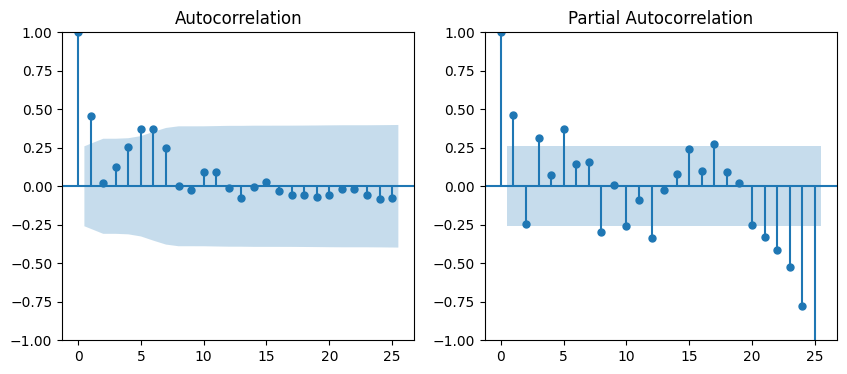

Значение теста ADF: -3.5836708658260292
p-value: 0.006080989753876957
Использовано лагов: 11
Количество наблюдений 45
Критические значения: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}

P-value меньше 0.05, нулевую гипотезу (Ho) можно отвергнуть. 
Ряд стационарен.


In [32]:
# Графики ACF и PACF из стационарного ряда
plot_acf_pacf(train_df["GDP (current US$)"].diff(d).dropna(), 25, 10, 4)
adfuller_test(train_df["GDP (current US$)"].diff(d).dropna())

Определяем параметры $p$ и $q$ из коррелограмм выше. Выбираем:  
$p$ = 1  
$d$ = 2  
$q$ = 3  
  
Помио этого, проведём поиск наилуших параметров $p, q$ с помощью пакета `pmdarima`. Значение $d$ нам известено ─ 2, поэтому явно указываем его в установках параметров. Значение $m$ устанваливаем в 1, так как у нас сезонности нет (годичная), в мануале написано:  
>" Например, m равно 4 для квартальных данных, 12 для месячных данных или 1 для годовых (несезонных) данных. Значение по умолчанию — 1. Обратите внимание, что если m == 1 (т. е. не является сезонным), `seasonal` будет установлено в False. "

In [33]:
# Подбор наилучших параметров
smodel = pm.auto_arima(
    train_df, 
    start_p=1, 
    max_p=3, 
    start_q=1,
    max_q=3, 
    d=2, 
    test='adf',
    m=1,
    start_P=0, 
    seasonal=False,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
    )

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 20 Feb 2023   AIC                           2680.765
Time:                        18:37:48   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

Найденные наилучшие параметры с помощью пакета pmdarima (1, 2, 3) совпадают с теми, которые были определены "вручную" ─ (1, 2, 3).  

$\Large{\textbf{\color{darkgreen}{Задание 1.4}}}$  
Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [34]:
# Построение модели с наилучшими параметрами
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order = (1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 20 Feb 2023   AIC                           2680.765
Time:                        18:37:48   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

In [35]:
# Предсказание для тестовой выборки
pred_df = pd.DataFrame(index = df.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df['GDP (current US$)'] = df['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

$\Large{\textbf{\color{darkgreen}{Задание 1.5}}}$  
Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

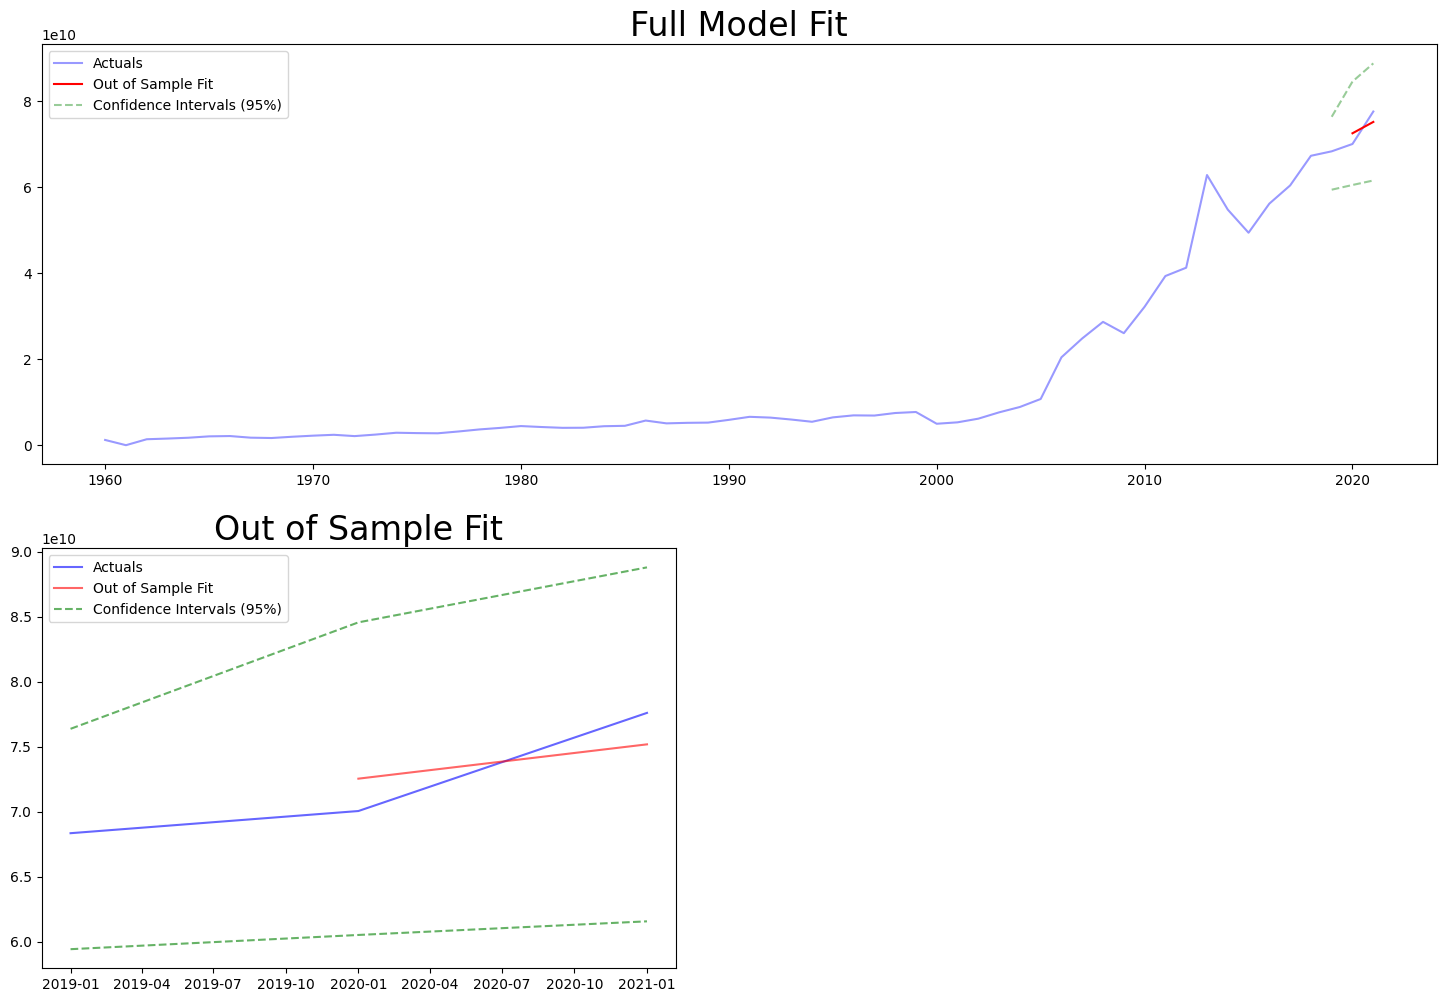

In [36]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP (current US$)'], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]['GDP (current US$)'], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show();

$\Large{\textbf{\color{darkgreen}{Задание 1.6}}}$  
Сделайте выводы.  
  
Модель уловила тренд. Предсказанные значения фондового индекса входят в 95%-ый доверительный интервал и пересекаются с тестовыми данными.

$\huge{\textnormal{\color{Peru}{2. Интерполяция и семплирование}}}$  
  
$\Large{\textbf{\color{darkgreen}{Задание 2.1}}}$  
Проверьте данные на наличие пропущенных дат. Помимо визуального способа это можно сделать с помощью метода *DataFrame.asfreq()*, передав в него параметр частоты, например, 'd' ─ день, 'm' ─ месяц.

In [37]:
# Проверка данных на пропуски в датах  
df = pd.read_csv('data/ghana_gdp.zip', parse_dates=["year"], index_col = ["year"])

display(df.head())
if df.shape == df.asfreq(freq='AS').shape:
    print("Пропущенных дат нет")
else:
    print("Имеются пропущенные даты")

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Пропущенных дат нет


$\Large{\textbf{\color{darkgreen}{Задание 2.2}}}$  
Проверьте данные на наличие пропущенных значений.

In [38]:
# Проверка df
inf(df)

Строки: 62 
Признаки: 1 
Дубликаты: 0 
Пропуски: NaN not detected.


$\Large{\textbf{\color{darkgreen}{Задание 2.3}}}$  
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на *NaN*. 

In [39]:
# Замена найденных нулей на NaN
df.loc[df["GDP (current US$)"].eq(0), "GDP (current US$)"] = np.nan
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


$\Large{\textbf{\color{darkgreen}{Задание 2.4}}}$  
Заполните пропуски, выполнив интерполяцию с использованием метода *.interpolate()*

In [40]:
# Выполнение интерполяции  
InterPol = pd.DataFrame(df.interpolate(method='linear'), columns = ["GDP (current US$)"])
InterPol.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


$\Large{\textbf{\color{darkgreen}{Задание 2.5}}}$  
Проверьте полученный ряд на стационарность, определите параметры модели *(ARIMA/ARMA)* и запустите модель.

In [41]:
# делаем train-выборку
train_df = InterPol.loc[:"2018-01-01"]
# для test-выборки используем последние три года
test_df = InterPol.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [42]:
# Проверка на стационарность
adfuller_test(train_df['GDP (current US$)'])

Значение теста ADF: 0.8030073326980115
p-value: 0.9916845572455877
Использовано лагов: 10
Количество наблюдений 48
Критические значения: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Полученные данные не позволяют отвергнуть нулевую гипотезу. 
Ряд нестационарен.


Поскольку ряд нестационарен, то проводим дифференцирование и определяем параметр $d$ ─ порядок дифференцирования.

In [47]:
# Дифференциация и определение порядка DS-ряда
d = diff(train_df['GDP (current US$)'])
print(f"При d = {d} ряд становится стационарным\n")
adfuller_test(train_df["GDP (current US$)"].diff(d).dropna())

При d = 2 ряд становится стационарным

Значение теста ADF: -3.99980344094915
p-value: 0.0014115408436661263
Использовано лагов: 11
Количество наблюдений 45
Критические значения: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}

P-value меньше 0.05, нулевую гипотезу (Ho) можно отвергнуть. 
Ряд стационарен.


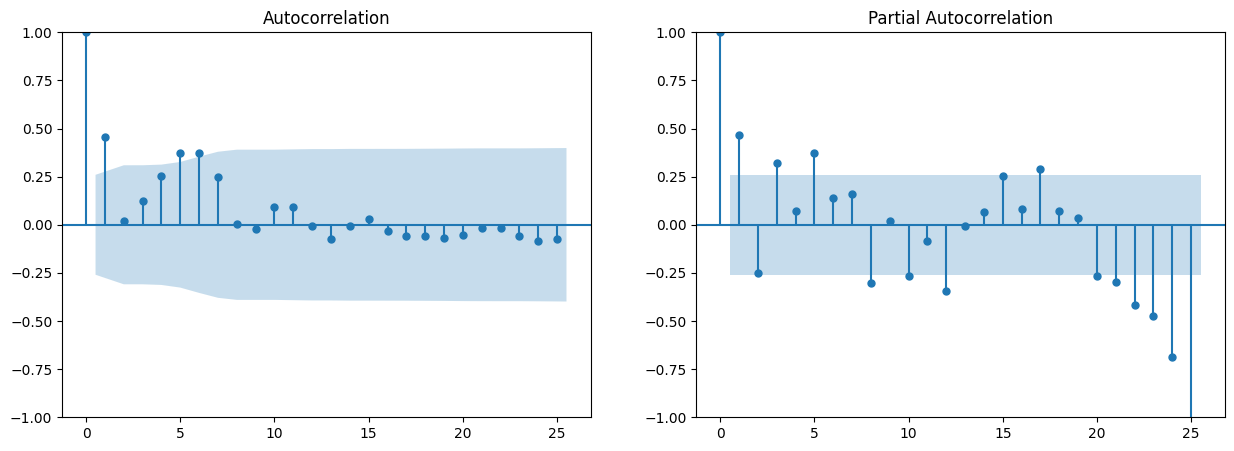

In [44]:
# Графики ACF и PACF стационарного ряда
plot_acf_pacf(train_df["GDP (current US$)"].diff(d).dropna(), 25, 15, 5)

По коррелограммам определяем параметры:  
  
$p = 1$  
$d = 2$  
$q = 3$  
  
Также видно, что диаграммы с интерполяцией практически не отличаются от диаграмм без интерполяции. Полагаю, что это вызвано тем, что с нулём было только одно значение и в той области кривой, где тренд был выражен весьма слабо.  
  
Определяем наилучшие параметры с помощью `auto_arima`.

In [45]:
# Подбор наилучших параметров
smodel = pm.auto_arima(
    train_df, 
    start_p=1, 
    max_p=7, 
    start_q=1,
    max_q=7, 
    d=2, 
    test='adf',
    m=1,
    start_P=0, 
    seasonal=False,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
    )

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 20 Feb 2023   AIC                           2680.513
Time:                        18:37:50   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+55. Standard errors may be unstable.
"""

Полученные параметры $p, q$ совпадают с параметрами, определёнными "вручную". Строим модель.

In [46]:
# Построение модели с наилучшими параметрами
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order = (1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 20 Feb 2023   AIC                           2680.513
Time:                        18:37:50   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+55. Standard errors may be unstable.
"""

$\Large{\textbf{\color{darkgreen}{Задание 2.6}}}$  
Изменился ли *AIC* критерий построенной модели по сравнению с моделью на неинтерполированных данных?  
Сделайте вывод.  
  
*AIC* на неинтерполированной модели равен 2680.765  
*AIC* на интерполированной модели равен 2680.513  
Критерий *AIC* построенной модели по сравнению с моделью на неинтерполированных данных изменился.  
Стал лучше на 0.252.  Интерполяция, восстановив промежуточное значение, немного улучшила прогноз.  